In [25]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
import pickle

# None 3, 20
# 2 has 52, 31
# 3 has 52, 22

file_path = '/vol/aimspace/users/kaiserj/Individual_Privacy_Accounting/results_coco/coco_unsupervised3.pkl'

class CocoDataset(Dataset):
    def __init__(self, coco_cap, coco_ann, image_dir, transform=None, classes=[52, 22], image_count=1000):
        self.coco_cap = coco_cap
        self.coco_ann = coco_ann
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = []
        for img_id in self.coco_ann.imgs:
            anns = self.coco_ann.loadAnns(self.coco_ann.getAnnIds(imgIds=img_id))
            cap = self.coco_cap.loadAnns(self.coco_cap.getAnnIds(imgIds=img_id))[0]['caption']
            if len(cap) < 10:
                print(cap)
            if any(ann['category_id'] in classes for ann in anns):
                self.image_ids.append(img_id)
        self.image_ids = self.image_ids[0:image_count]
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        ann = self.coco_cap.loadAnns(self.coco_cap.getAnnIds(imgIds=image_id))[0]
        caption = ann['caption']
        image_info = self.coco_cap.loadImgs(image_id)[0]
        image_path = self.image_dir + "/" + image_info['file_name']
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, caption, image_id
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

coco_cap = COCO('/vol/aimspace/users/kaiserj/Datasets/Datasets_Raw/coco/annotations/captions_train2017.json')
coco_ann = COCO('/vol/aimspace/users/kaiserj/Datasets/Datasets_Raw/coco/annotations/instances_train2017.json')
image_dir = '/vol/aimspace/users/kaiserj/Datasets/Datasets_Raw/coco/train2017'
dataset = CocoDataset(coco_cap, coco_ann, image_dir, transform=transform)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=10.25s)
creating index...
index created!


In [26]:
def load_pickle_file(file_path):
    """
    Load data from a pickle file.

    :param file_path: str, path to the pickle file
    :return: data loaded from the pickle file
    """
    try:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except pickle.UnpicklingError:
        print(f"Error: The file {file_path} could not be unpickled.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Example usage
data = load_pickle_file(file_path)
print("")

In [27]:
# Zip the lists together
kl_data = data["kl"][0]
idx = data["idx"]
idx_all = data["idx_all"].tolist()
kl0 = [dat[0] for dat in kl_data]
kl1 = [dat[1] for dat in kl_data]
kl_comb = [dat[0] + dat[1] for dat in kl_data]

combined0 = list(zip(kl0, idx, idx_all))
combined_sorted_kl0 = sorted(combined0, key=lambda x: x[0])
kl0_sorted, idx_sorted_kl0, idx_all_sorted_kl0= zip(*combined_sorted_kl0)

combined1 = list(zip(kl1, idx, idx_all))
combined_sorted_kl1 = sorted(combined1, key=lambda x: x[0])
kl1_sorted, idx_sorted_kl1, idx_all_sorted_kl1= zip(*combined_sorted_kl1)

combined_comb = list(zip(kl_comb, idx, idx_all))
combined_sorted_kl_comb = sorted(combined_comb, key=lambda x: x[0])
kl_comb_sorted, idx_sorted_kl_comb, idx_all_sorted_kl_comb= zip(*combined_sorted_kl_comb)


In [28]:
import matplotlib.pyplot as plt
import textwrap
import torch

max_caption_width = 30

def plot_images_with_captions(indices_set1, indices_set2, check_set1, check_set2):
    """
    Plots two 5x5 grids of images and captions.
    
    :param indices_set1: list of 25 indices for the first 5x5 grid
    :param indices_set2: list of 25 indices for the second 5x5 grid
    """
    assert len(indices_set1) == 25 and len(indices_set2) == 25, "Each index set must contain exactly 25 indices."

    fig, axes = plt.subplots(12, 5, figsize=(15, 30))

    for ax in axes[0][:]:
        ax.set_axis_off()
    fig.suptitle("Low LSI", fontsize=20, y=0.95)

    for ax in axes[6][:]:
        ax.set_axis_off()
    fig.suptitle("High LSI", fontsize=20, y=0.45)

    print(f"Set1 {check_set1}")
    for i in range(25):
        # Calculate grid position for the first set of indices
        row1, col1 = divmod(i, 5)
        row1 += 1
        # Retrieve image and caption for the first set of indices
        image1, caption1, true_idx1 = dataset.__getitem__(indices_set1[i])
        print(true_idx1)
        assert true_idx1 in check_set1
        image1 = torch.permute(image1, (1, 2, 0))
        # Plot the image
        axes[row1, col1].imshow(image1)
        # Set the caption as the title with line breaks
        axes[row1, col1].set_title("\n".join(textwrap.wrap(caption1, max_caption_width)))
        # Remove axis
        axes[row1, col1].axis('off')

        # Calculate grid position for the second set of indices
        row2, col2 = divmod(i, 5)
        row2 += 7  # Shift down by 5 rows
        # Retrieve image and caption for the second set of indices
        image2, caption2, true_idx2 = dataset.__getitem__(indices_set2[i])
        assert true_idx2 in check_set2
        image2 = torch.permute(image2, (1, 2, 0))
        # Plot the image
        axes[row2, col2].imshow(image2)
        # Set the caption as the title with line breaks
        axes[row2, col2].set_title("\n".join(textwrap.wrap(caption2, max_caption_width)))
        # Remove axis
        axes[row2, col2].axis('off')

    plt.tight_layout()
    save_dir = "/vol/aimspace/users/kaiserj/Individual_Privacy_Accounting/mimic_experiments/plot_functions_upd/results_new/"
    save_name = save_dir + "contrastive"
    plt.savefig(save_name + ".png", format="png", dpi=1000)
    print(f"saving fig as {save_name}.png")
    plt.savefig(save_name + ".pdf", format="pdf", dpi=1000)
    print(f"saving fig as {save_name}.pdf")
    plt.savefig(save_name + ".svg", format="svg")
    print(f"saving fig as {save_name}.svg")
    plt.show()


In [29]:
print("")

low_kl0 = idx_sorted_kl0[0:25]
low_kl1 = idx_sorted_kl1[0:25]
low_kl_comb = idx_sorted_kl_comb[0:25]

high_kl0 = idx_sorted_kl0[-25:]
high_kl1 = idx_sorted_kl1[-25:]
high_kl_comb = idx_sorted_kl_comb[-25:]


low_kl0_idx = idx_all_sorted_kl0[0:25]
low_kl1_idx = idx_all_sorted_kl1[0:25]
low_kl_comb_idx = idx_all_sorted_kl_comb[0:25]

high_kl0_idx = idx_all_sorted_kl0[-25:]
high_kl1_idx = idx_all_sorted_kl1[-25:]
high_kl_comb_idx = idx_all_sorted_kl_comb[-25:]

Set1 (495975, 460559, 165164, 422536, 260166, 121633, 46650, 85688, 506187, 511724, 396608, 331138, 165818, 235244, 394458, 48383, 441287, 312204, 240273, 140713, 120918, 452414, 455746, 310202, 403345)
495975
460559
165164
422536
260166
121633
46650
85688
506187
511724
396608
331138
165818
235244
394458
48383
441287
312204
240273
140713
120918
452414
455746
310202
403345


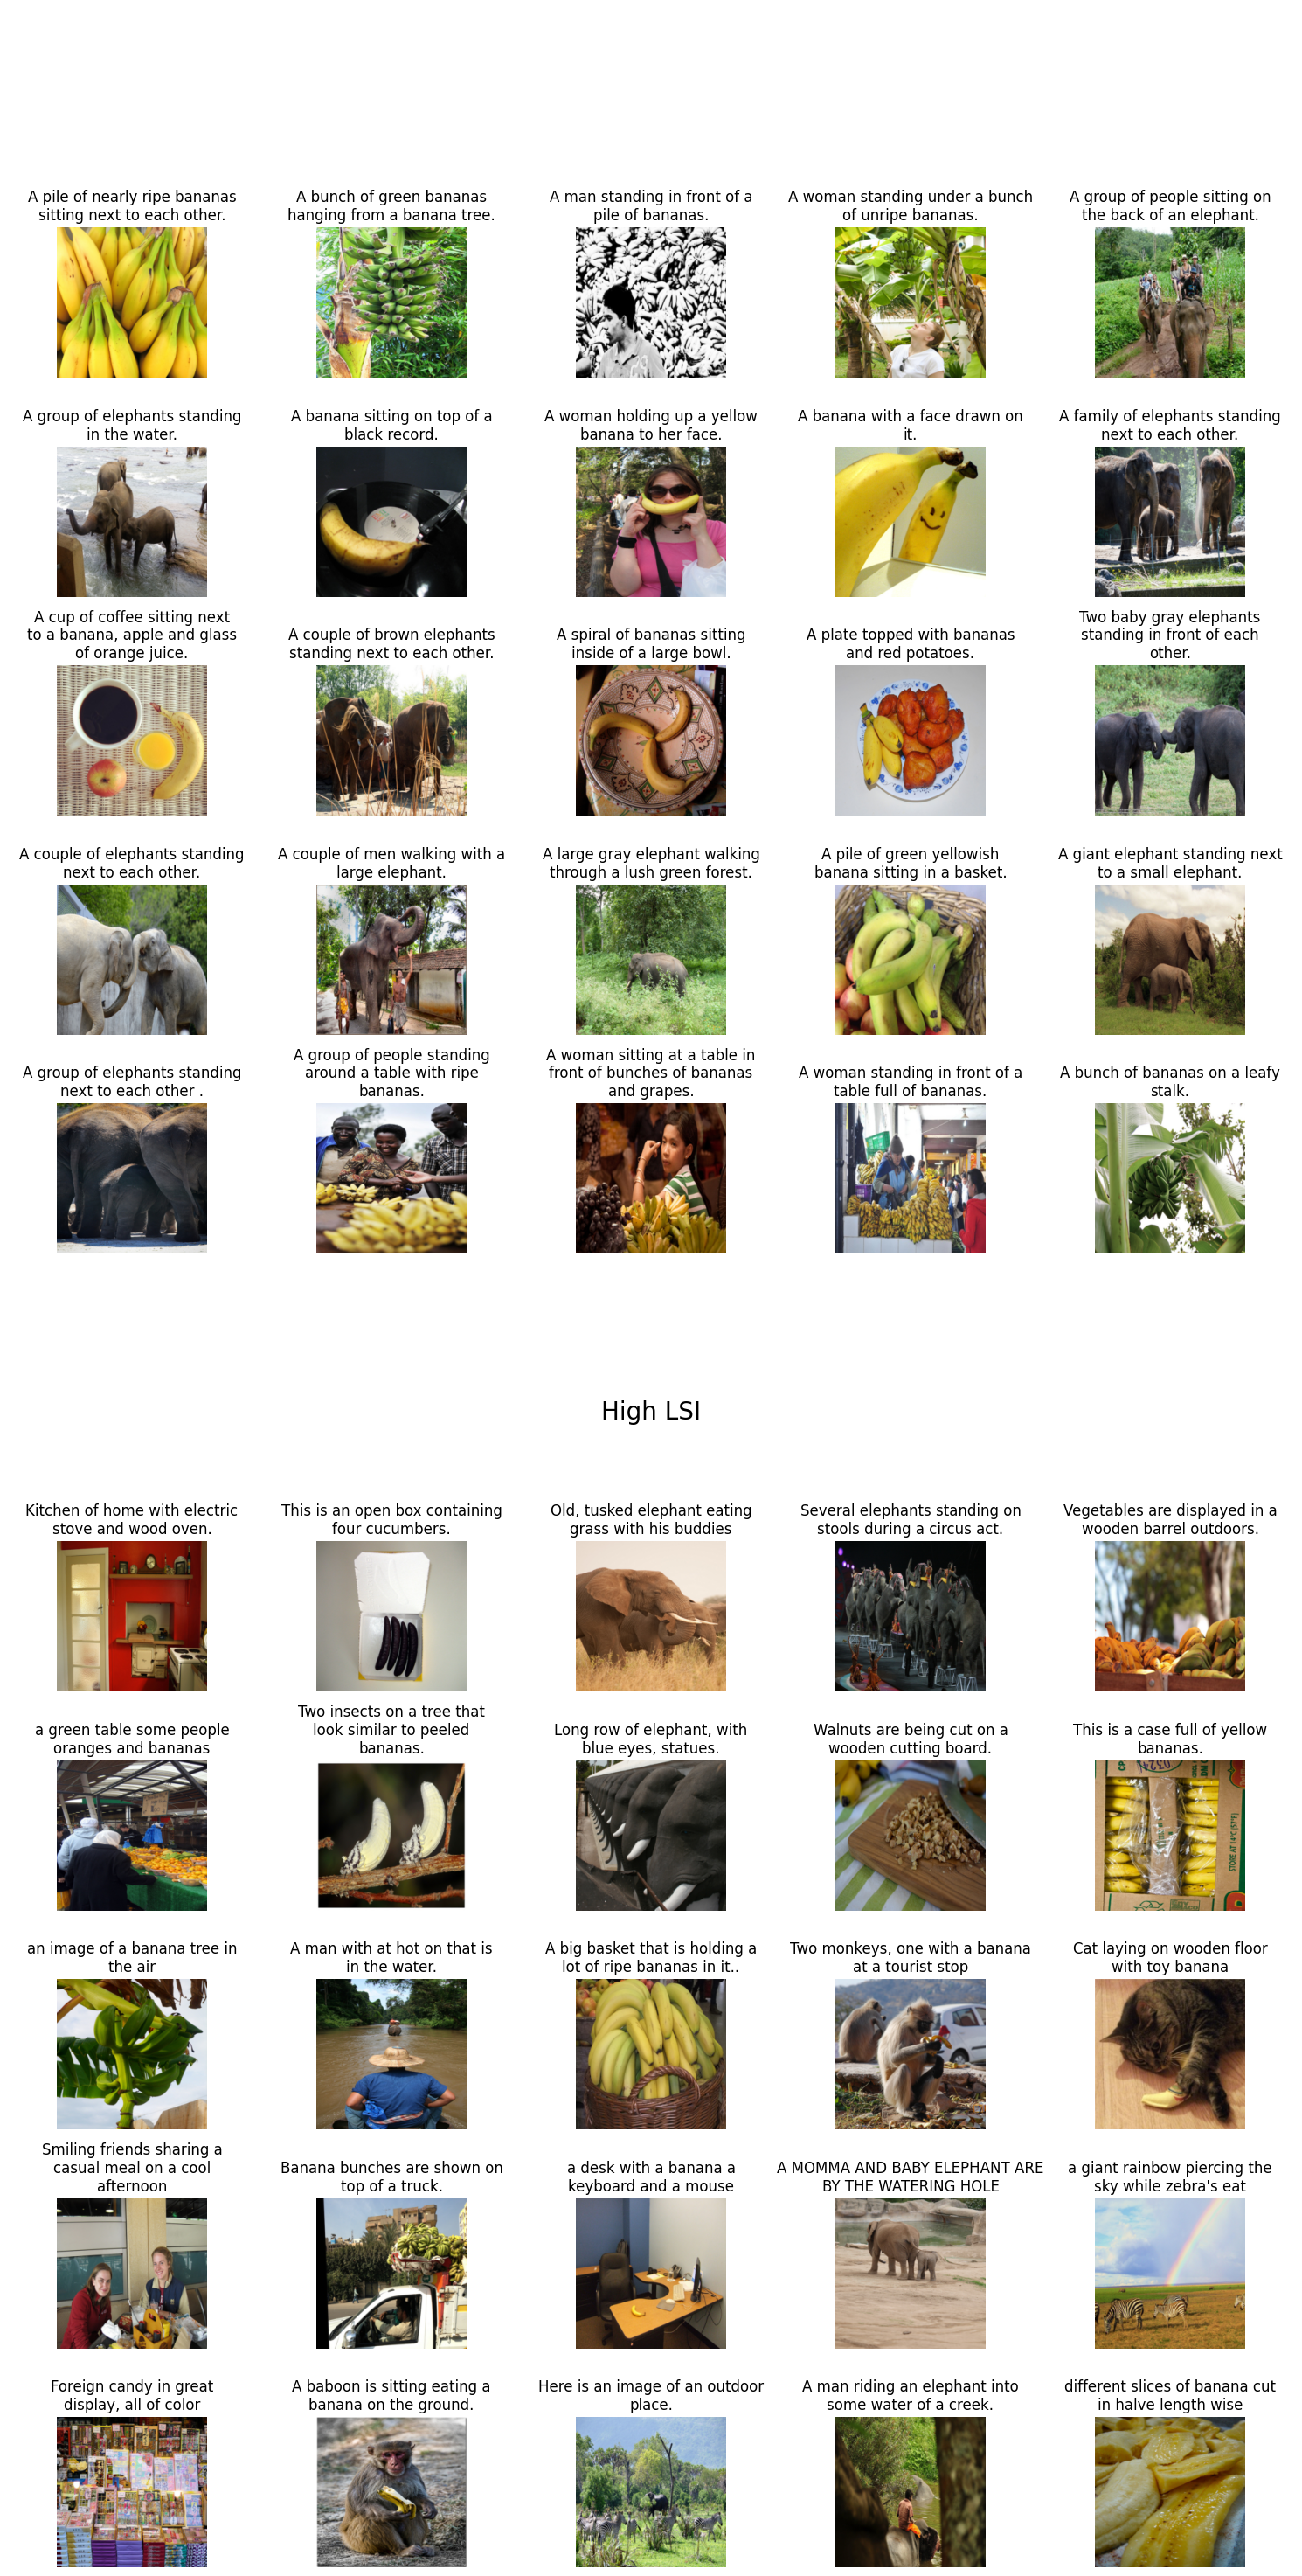

In [30]:
#######
# KL1
####

# Low KL Images
# HIgh KL Images

plot_images_with_captions(low_kl1, high_kl1, low_kl1_idx, high_kl1_idx)